# 0. 함수형 api
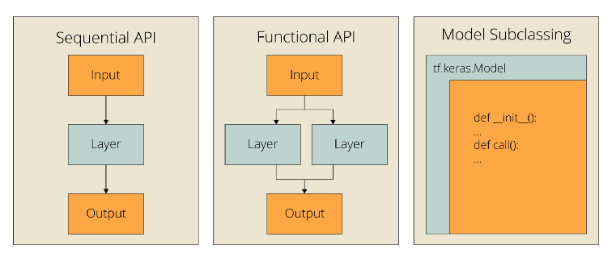

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(10,))
hidden1 = Dense(64, activation='relu')(inputs)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=inputs, outputs=output) #처음꺼와 끝으로 모델 만들기

In [ ]:
# 밑의 두개의 result값은 같음
# 1
result = Dense(128)(input)
# 2
dense = Dense(128)
result = dense(input)

## 다중 입력 받는 모델

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model

# 두 개의 입력층을 정의
inputA = Input(shape=(64,))
inputB = Input(shape=(128,))

# 첫번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
x = Dense(16, activation="relu")(inputA)
x = Dense(8, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

# 두번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

########## 두개의 인공 신경망의 출력을 연결(concatenate) ###############
result = concatenate([x.output, y.output])

z = Dense(2, activation="relu")(result)
z = Dense(1, activation="linear")(z)

model = Model(inputs=[x.input, y.input], outputs=z)

# fit, predict할때도 input값 두개
model.fit([x1,x2],y1)

model.predict([x1,x2])

### -두 output concatenate할때 shape이 마지막 축 빼고 동일하면 가능
(None, 8) + (None, 8) → OK  
(None, 8) + (None, 16) → OK  
(None, 8, 32) + (None, 8, 32) → OK  
(None, 8, 32) + (None, 10, 32) → ❌ (두 번째 차원이 다름)  

### -concat의 의미 : 유전자 + 환경 등 서로 다른 입력을 하나로 합침
         InputA (64-dim)             InputB (128-dim)
             │                           │
         Dense(16)                  Dense(64)
             │                           │
         Dense(8)                   Dense(32)
             │                           │
                                        Dense(8)
             └───────┬────────────┬─────┘
                     │         concatenate
                     ▼
              Concatenated vector (8 + 8 = 16)  # 총 (16,)의 벡터가 되어 2개뉴런짜리 밀집층에 들어감 
                     │
                Dense(2)
                     │
                Dense(1) → 최종 출력

                
### -Model(inputs=[x.input, y.input], outputs=z)
x.input == inputA, y.input == inputB이므로 Model(inputs=[inputA, inputB], outputs=z)이렇게도 가능

### -모델 안말들고 그전에 concat가능
최종 x,y에 대해 result = concatenate([x, y])

### -출력 여러개도 가능
저 result를 a층의 Dense(8)->dense(1)에 넣고 result를 b층의 dense(64)->dense(8)->dense(1)에 넣고 model(inputs,outputs=[a,b])하면 두개의 결과값이 출력

## 서브클래싱 api

In [ ]:
#서브 클래싱
class LinearRegression(tf.keras.Model): # 상속통해 compile, fit, evaluate, predict 쓸수있게됨
  def __init__(self):    # model=LinearRegression() 이런식으로 생성할수있게
    super(LinearRegression, self).__init__() #  본인 이름 들어감 -> Keras 내부에서 사용하는 속성들 초기화
                                 # Keras가 자동으로 모델 학습/평가/저장에 필요한 내부 속성을 준비하기 때문
                                  # 그러면 fit과 같은 메서드 사용에 에러가 날 수 있음
    self.linear_layer = tf.keras.layers.Dense(1, input_dim=1, activation='linear')

  def call(self, x): # forward 연산 정의 -> Keras에서 모델에 입력을 주면 자동으로 call()이 실행
    y_pred = self.linear_layer(x)   # -> y_pred = model(x) -> 그냥 x만 넣어 내부적으로 model.call(x) 호출됨
    return y_pred


# 모델 설정+학습
model = LinearRegression()
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['mse'])
model.fit(x, y, epochs=300)

# 1. sequence to sequence(seq2seq)
- 인코더: 입력 시퀀스를 요약된 의미(벡터)로 압축  /  디코더: 그 벡터를 기반으로 출력 시퀀스를 생성
- 인코더로 데이터를 받아들여 context vector(hidden state)로 전환해 decoder에서 받아들여 변환해 출력
- 번역기와 유사  
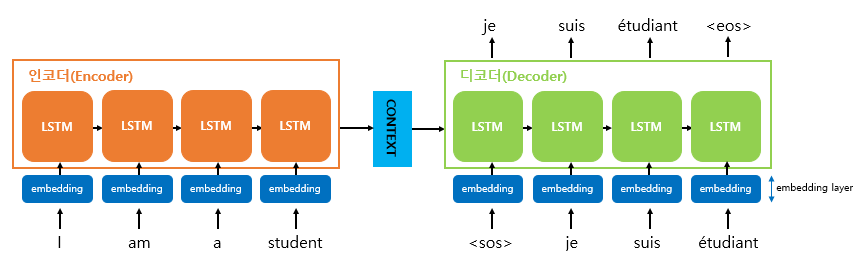
- 인코더에서는 return_sequence=False로 하여 인코더의 마지막 상태값(context vector)이 문장 전체를 요약했다고 가정
- 디코더는 return_sequence=True로 출력 시퀀스를 한 step씩 다 예측

## 디코더 내부
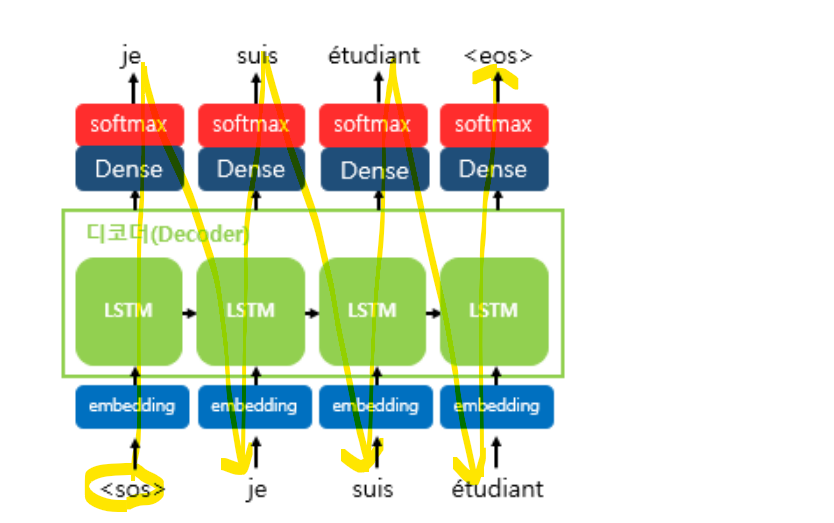  
- 인코더의 최종 은닉상태인 context 벡터가 디코더에 전달되고 이 값과 <sos> start of sentence값으로 softmax로 je 예측
- 똑같이 두번째에서는 이전 디코더의 hidden state(context vector+<sos>임베딩 값이 lSTM에 들어간 값)와 je의 임베딩값으로 softmax후 다음에 나올 suis예측
- 이런식으로 하나씩 뽑으며 마지막은 end of sentence
- 소프트맥스 함수를 통해 vocabulary에 있는 모든 단어 중 제일 확률 높은 단어 가져와 출력

## seq2seq 모델 생성(함수형 api를 통해)

In [1]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense # 함수형 api위해서는 input층도 따로 필요
from tensorflow.keras.models import Model # 함수형 api해해
import numpy as np

In [ ]:
## data
encoder_input # 입력 임베딩값
decoder_input # 이전 시점의 예측이 틀릴경우 담것도 틀릴확률 증가-> 소모시간 증가-> 이를 방지하기위해 실제 정답값 넣어줌 
decoder_target # 정답

## 모델 생성

# 1. 인코딩층
encoder_inputs = Input(shape=(None, src_vocab_size)) #None->입력크기를 가변적으로(내부에서 길이 다르면 padding함), vocab은 총 단어개수로 embedding에 사용
encoder_lstm = LSTM(units=256, return_state=True) # 인코딩 순환층(return_sequence=False), return_state=True: hidden state, cell state반환

# 2. 인코딩 결과
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) # 인코딩 결과 출력값
encoder_states = [state_h, state_c] # 디코더에 넘겨줄 초기 상태 벡터 두 개를 묶은 리스트 -> 디코더의 initial_state= 인자로 들어감

# 3. 디코딩 층 
decoder_inputs = Input(shape=(None, tar_vocab_size)) # 디코더에 들어갈 입력층
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True) # 디코더 순환층

# 4. 디코더에게 인코더의 은닉 상태,셀 상태를 전달. *** [state_h, state_c]==context vector ***
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states) # 여기에 inital_state에 인코딩 초기상태 벡터 두개 전달

# 5. dense+softmax층 생성
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs) # 마지막 층

# 6. 최종 seq2seq모델 생성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # 함수형api->처음 층과 마지막 층, 4번에 의해 concat돼싸 볼수있음
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

# 7. 학습-> x에 encoder_input, decoder_input같이 들어감
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

# 2. attention메커니즘
- seq2seq의 한계: input을 컨텍스트 벡터라는 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생
- 이를 보완하기 위해 attention
- ***디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고***  
        ->이때 전부가 아닌 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 봄

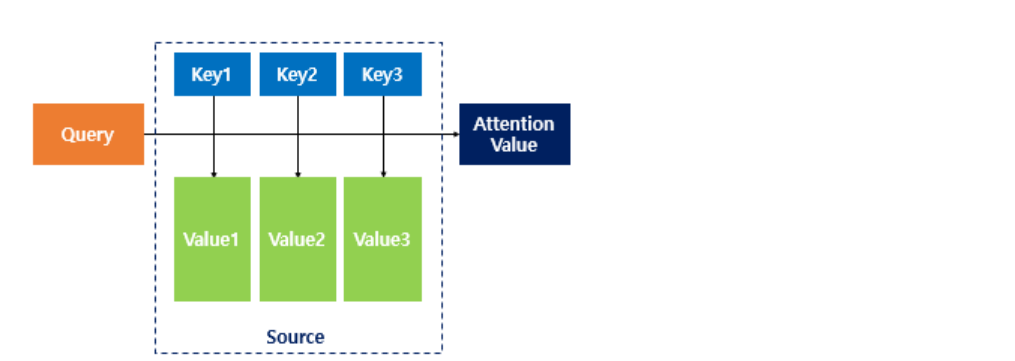  
- 어텐션함수: Attention(Q, K, V) = Attention Value  
    -> Query에 대해 모든 Key와의 유사도를 각각 구함 -> 이 유사도를 키와 맵핑되어있는 각각의 Value에 반영-> 얘들을 다 더해 attention value로
- seq2seq에서의 attention  
Q = Query : t 시점의 디코더 셀에서의 은닉 상태(이전 디코더 은닉상태+ 이전단어 임베딩 값이 LSTM지나서 나온 은닉상태)  
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들(인코더에서 return_sequence=True했을때의 모든 은닉값)  
V = Values : 모든 시점의 인코더 셀의 은닉 상태들(여기에 다시 attention 가중치를 곱해주게 됨)  

## 닷-프로덕트 어텐션(Dot-Product Attention)
- 여러 attention들 중 가장 이해하기 쉬운 예시  
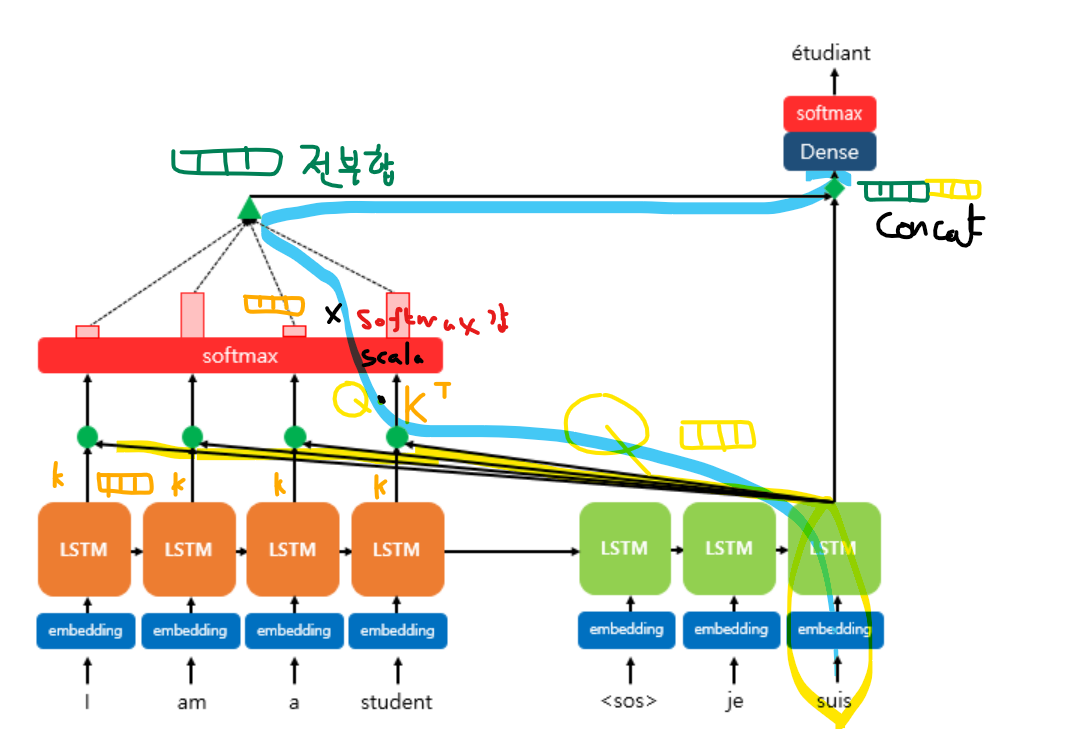
- 디코더의 세번째 출력단어 예측: 현재 디코더 은닉상태에 새로운 attention value필요  
1. 인코더의 모든 입력단어 참고(key참고) -> 현 시점 디코더의 은닉값을 인코더의 모든 단어의 은닉값과 곱함(여러 스칼라값들) -> 이 값들이 어텐션 스코어
2. 어텐션스코어들을 소프트맥스화(빨간네모) -> 어텐션 가중치라부름: 단어 각각이 출력단어를 예측할때 얼마나 도움이 되는지를 수치화한것(총합은 1)
3. 각각의 어텐션 가중치를 해당 인코더의 해당 단어의 은닉값과 곱하고 다 더해 가중합값 하나==attention value (벡터)
4. attention value와 현재 디코더의 은닉상태를 연결(concatenate)하여 하나의 벡터로
5. 이 벡터를 한번더 신경망 연산과 tanh함수를 지나게 해 새로운 벡터로
6. 이 벡터를 마지막 출력층에 넣고 softmax화 하여 제일 값 높은 단어를 예측 

# 3. 양방향 LSTM + 어텐션 메커니즘
- 양방향은 하나는 앞에 단어에서부터, 하나는 뒤에단어에서부터 역으로 시작
- from keras.layers import Bidirectional 하고 Bidirectional(LSTM( ))하면 됨

In [1]:
import tensorflow as tf

## 바다나우 어텐션 미리 정의 -> 이거 앞으로 계속 쓰면  됨

In [2]:
# 바다나우 어텐션 사용
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## BiLSTM + 바다나우 어텐션 합치기
- 요약: 임베딩 → 양방향 LSTM 2층 → Bahdanau Attention → Dense → 출력
## 이때 attention에 lstm과 hidden state만 들어감(cell state는 안들어감) !!!!!!

In [3]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
# 입력층
sequence_input = Input(shape=(max_len,)) # max_len은 문장 길이

# 임베딩 층
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input) #128차원으로

# 첫번째 양방향 LSTM층
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences) #두번째 층에 넣기위해 return

# 두번째 양방향 LSTM층 (h-은닉상태=단기기억, c-셀상태=장기기억)
# forward_h, forward_c: 순방향 LSTM의 마지막 은닉 상태, 셀 상태  
# backward_h, backward_c: 역방향 LSTM의 마지막 은닉 상태, 셀 상태  
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \  # \는  줄바꿈을 허용
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm) # seq=True로 해야 각 단어의 각 은닉값 뽑아와 어텐션에 넣을수있음 !!!!!!!!! 

# 양방향 각 상태들을 연결(keras.layers의 Concatenate사용)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

# 여태 쌓아온 **lstm(K,V)**결과와 **은닉상태(Q)** 어텐션에 넣어 컨텍스트 벡터 얻기
attention = BahdanauAttention(64) # 가중치 크기 정의한 어텐션
context_vector, attention_weights = attention(lstm, state_h) # 어텐션 점수 계산 → 가중합 → attention context vector 생성(인코더꺼랑 다름)

# context vector를 밀집흥+ 시그모이드에 넣어 이진분류모델 생성 
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout) # 이진분류이므로 뉴런1개
model = Model(inputs=sequence_input, outputs=output)

#compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)